In this module, we study how to implement other variants of the K-means clustering algorithm, with the focus on categorical variables. Since K-means requires that data be numeric, we need to think about how to handle categorical data or mixed data types. It turns out that K-modes is used for clustering categorical variables. It defines clusters based on the number of matching categories between data points (this is in contrast to the more well-known K-means algorithm, which clusters numerical data based on Euclidean distance). The K-prototypes algorithm combines K-modes and K-means and is able to cluster mixed numerical/categorical data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist, pdist

%matplotlib inline

Let's use the titanic dataset as an example. This dataset has both categorical and numeric data. We will only keep the categorical variable for the purpose of illustration. 

In [2]:
path='C:\\Users\\pgao\\Documents\\PGZ Documents\\Programming Workshop\\PYTHON\\Open Courses on Python\\Udemy Course on Python\\Introduction to Data Science Using Python\\datasets'
os.chdir(path)
titanic = pd.read_csv('titanic.csv')
print(titanic.info())
titanic.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now let's create all the dummies and drop the majority of the numeric variables:

In [3]:
titanic.drop(['Name','Age', 'Parch', 'SibSp', 'Ticket', 'Fare', 'PassengerId', 'Cabin'], axis=1, inplace=True)
df=titanic
print(df.groupby('Survived').size(), '\n')
print(df.groupby('Pclass').size(), '\n')
print(df.groupby('Embarked').size(), '\n')
sex = pd.get_dummies(df['Sex'],drop_first=False) # drop_first=True implies dropping the first column to avoid multicollinearity
embark = pd.get_dummies(df['Embarked'],drop_first=False)
df = pd.concat([df,sex,embark],axis=1) # adding in the dummy variable in the remaining 'DataFrame' object
df.drop(['Sex', 'Embarked'], axis=1, inplace=True)
df.head()

Survived
0    549
1    342
dtype: int64 

Pclass
1    216
2    184
3    491
dtype: int64 

Embarked
C    168
Q     77
S    644
dtype: int64 



,Survived,Pclass,female,male,C,Q,S
0,0,3,0,1,0,0,1
1,1,1,1,0,1,0,0
2,1,3,1,0,0,0,1
3,1,1,1,0,0,0,1
4,0,3,0,1,0,0,1


Before we move onto the analysis, let's keep in mind that missing data is something that we always should care about when it comes to clustering. The K-modes algorithm accepts np.NaN values as missing values in the input matrix. However, users are strongly suggested to consider filling in the missing data themselves in a way that makes sense for the problem at hand. This is especially important in case of many missing values.

The K-modes algorithm currently handles missing data as follows. When fitting the model, np.NaN values are encoded into their own category (let's call it "unknown values"). When predicting, the model treats any values in the input that (1) it has not seen before during training, or (2) are missing, as being a member of the "unknown values" category. Simply put, the algorithm treats any missing/unseen data as matching with each other but mismatching with non-missing/seen data when determining similarity between points. This is why we should always convert unknown values prior to training the model. 

The K-prototypes also accepts np.NaN values as missing values for the categorical variables, but does not accept missing values for the numerical values. It is up to the user to come up with a way of handling these missing data that is appropriate for the problem at hand.

Based on the previous frequency analysis, there are no missing data in given columns, so let's move on to the K-modes analysis:

In [4]:
km = KModes(n_clusters=3, init='Huang', n_init=5, verbose=0)
clusters = km.fit_predict(df)
print('Cluster Centroids: \n', km.cluster_centroids_)
print('Cluster Labels: \n', km.labels_)

Cluster Centroids: 
 [[1 3 1 0 0 0 1]
 [0 3 0 1 0 0 1]
 [0 3 0 1 1 0 0]]
Cluster Labels: 
 [1 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 2 1 0 1 2 0 0 1 2 1 2
 1 0 0 0 0 2 0 0 1 1 0 2 0 1 1 0 0 2 1 0 2 0 1 2 0 1 1 2 2 0 1 0 1 1 0 1 2
 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 2 2 0 1 0 1 1 1 1 1 0 1 1 0 1
 2 1 0 2 1 1 1 2 0 1 1 2 0 1 2 1 1 0 1 2 1 0 0 1 2 0 1 1 2 2 0 0 1 1 1 1 0
 1 1 1 0 1 1 1 2 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 2 1 1 2 1 1 0 2 1 1 0
 1 0 1 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 2 1 0 1 2 0 2 1 0 1 1 1 0 0 1 0 1 1 1
 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 2 0 1 1 2 1 0 0 1 1 1 0 1 1 0 0 0 0 0
 0 1 1 1 1 0 1 1 1 0 0 1 1 0 2 0 0 0 1 1 0 1 1 1 1 1 2 1 1 1 0 0 0 2 0 1 2
 2 0 1 0 0 1 1 0 1 1 0 0 2 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1
 1 0 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 2 1 2 1 0 0 0 0 1 2 2 1 1 1 0 0 0 0
 2 1 1 2 0 0 0 2 2 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1
 1 1 0 1 1 0 1 1 0 0 0 1 0 2 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0
 1 1 0 1 

Now let's use the elbow method to select the optimal hyperparameter:

Text(0.5,1,'Elbow for KModes clustering')

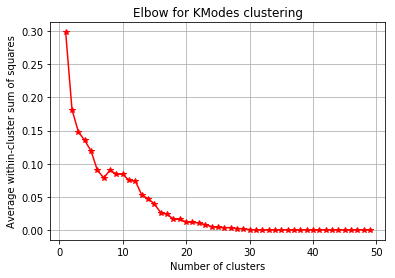

In [5]:
# kIdx = 9 # setting a generic K-value you want to highlight (the suspected K-value)

K_vec = range(1,50)
KM = [KModes(n_clusters=k).fit(df) for k in K_vec] # making a vector 
centroids = [j.cluster_centroids_ for j in KM]

D_k = [cdist(df, cent, 'hamming') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/df.shape[0] for d in dist]
wcss = [sum(d**2) for d in dist] # calculating total within sum of square
tss = sum(pdist(df)**2)/df.shape[0]
bss = tss-wcss

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K_vec, avgWithinSS, 'r*-')
# ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KModes clustering')

Now let's check the silhouette values:

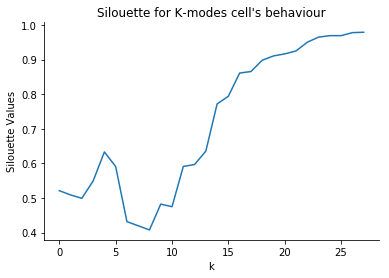

In [6]:
sv = [] # initializing a vector of silhouette values
for n_clusters in range(2,30):
    kmodes = KModes(n_clusters=n_clusters)
    kmodes.fit(df)
    labels = kmodes.labels_
    centroids = kmodes.cluster_centroids_
    sv.append(silhouette_score(df, labels, metric='hamming'))

plt.plot(sv)
plt.ylabel("Silouette Values")
plt.xlabel("k")
plt.title("Silouette for K-modes cell's behaviour")
sns.despine()

Additional Resources:
   - http://www.irma-international.org/viewtitle/10828/
   - https://github.com/nicodv/kmodes
   - https://stackoverflow.com/questions/13625849/knn-classification-with-categorical-data